# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [3]:
from maskmm.ipstartup import *
import os
import glob
import random
import skimage.io
from skimage.io import imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from maskmm.coco.config import Config
from maskmm.models.maskrcnn import MaskRCNN
from maskmm.datagen.dataset import Dataset
from maskmm.utils import visualize

import torch
from os.path import join

ROOT_DIR = "/home/ubuntu/maskmm"
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "data/models/mask_rcnn_coco.pth")
DATA = join(expanduser("~"), "data", "nuke") 

# reconfigure model for nuke
config = Config()
config.NUM_CLASSES = 2
config.CLASS_NAMES = ["BG", "Cell"]

model = MaskRCNN(model_dir=MODEL_DIR, config=config)
model.initialize_weights()

# load pretrained except final layers that depend on NUM_CLASSES
params = torch.load(COCO_MODEL_PATH)
params.pop('classifier.linear_class.weight')
params.pop("classifier.linear_bbox.weight")
params.pop("mask.conv5.weight")
params.pop('classifier.linear_class.bias')
params.pop("classifier.linear_bbox.bias")
params.pop("mask.conv5.bias")
model.load_state_dict(params, strict=False)
if config.GPU_COUNT:
    model = model.cuda()

[root:INFO]:starting (cellevents.py:36, time=21:00)


time: 1.99 s


In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

[root:INFO]:starting (cellevents.py:36, time=22:24)


time: 2.93 ms


## Dataset

In [4]:
# create validation sample
np.random.seed(0)
pvalid = .2
trainpath = join(DATA, "stage1_train")

df = pd.DataFrame(os.listdir(trainpath), columns=["image"])
df["subset"] = np.random.random(len(df))>pvalid
df.loc[df.subset==True, "subset"] = "train"
df.loc[df.subset==False, "subset"] = "valid"
df.to_pickle(join(DATA, "subset.pkl"))
df.subset.value_counts()

[root:INFO]:starting (cellevents.py:36, time=21:01)


train    505
valid    123
Name: subset, dtype: int64

time: 5.27 s


In [5]:
import nuke
config = Config()

dataset_train = Dataset(config)
dataset_train.load_nuke(DATA, "stage1_train")
dataset_train.prepare()

dataset_val = nuke.NukeDataset()
dataset_val.load_nuke(DATA, "stage1_train")
dataset_val.prepare()
config.display()

[root:INFO]:starting (cellevents.py:36, time=22:24)


HBox(children=(IntProgress(value=0, max=505), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))



Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        150
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 16
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [44.2054192  40.06826655 48.83986554]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuke
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING

[root:INFO]:starting (cellevents.py:36, time=22:24)


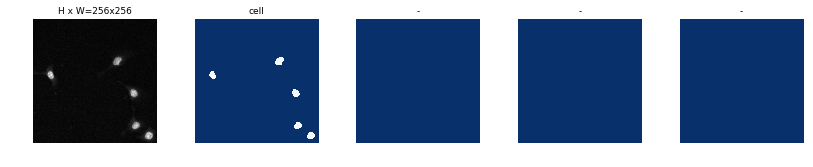

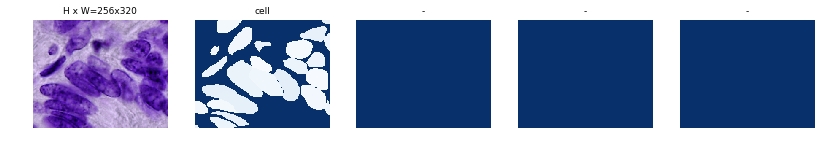

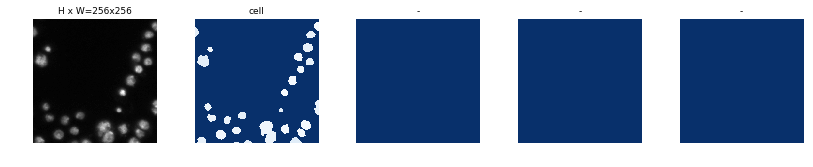

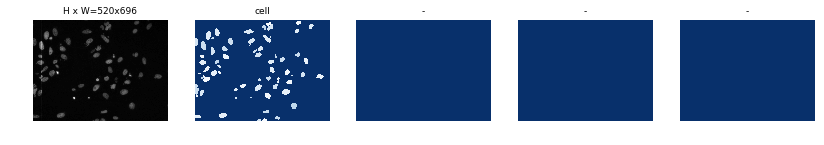

time: 1.81 s


In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

[root:INFO]:starting (cellevents.py:36, time=22:24)


time: 9.44 s


In [ ]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

[root:INFO]:starting (cellevents.py:36, time=22:25)


time: 6.66 s


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=.001, 
            epochs=10, 
            layers='heads')

[root:INFO]:starting (cellevents.py:36, time=22:24)



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/mask/logs/nuke20180207T2224/mask_rcnn_nuke_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4    

[tensorflow:WARNING]:From /home/ubuntu/mask/model.py:2071: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead (tf_logging.py:118, time=22:24)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


KeyboardInterrupt: 

time: 9.84 s


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=.001,
            epochs=30, 
            layers="all")

[root:INFO]:starting (cellevents.py:36, time=22:25)



Starting at epoch 24. LR=0.001

Checkpoint Path: /home/ubuntu/mask/logs/nuke20180207T1548/mask_rcnn_nuke_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b    

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

# Predict on valid set

In [17]:
class InferenceConfig(nuke.NukeConfig):
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

[root:INFO]:starting (cellevents.py:36, time=21:25)


Loading weights from  /home/ubuntu/mask/logs/nuke20180207T1548/mask_rcnn_nuke_0020.h5
time: 13.2 s


[root:INFO]:starting (cellevents.py:36, time=21:25)


26
original_image           shape: (512, 512, 3)         min:    1.00000  max:  248.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (94,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (94, 4)               min:    2.00000  max:  512.00000
gt_mask                  shape: (512, 512, 94)        min:    0.00000  max:  255.00000


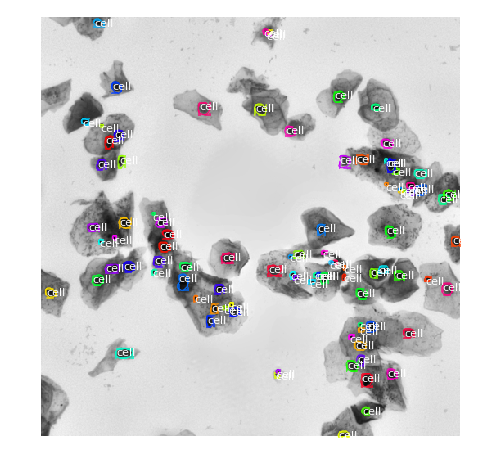

time: 3.24 s


In [18]:
# Test on a random image
image_id = 26 #random.choice(dataset_val.image_ids)
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

[root:INFO]:starting (cellevents.py:36, time=21:25)


Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  248.00000
molded_images            shape: (1, 512, 512, 3)      min:  -47.83987  max:  207.93173
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


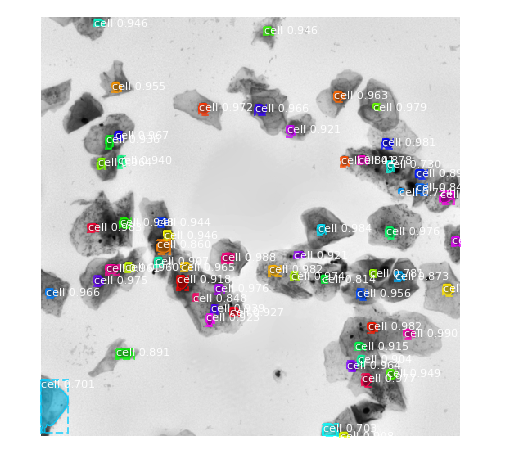

time: 6.03 s


In [19]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# Score

In [20]:
from tqdm import tqdm_notebook as tqdm
def score(image_ids, verbose=False):
    """ return mean average precision across range of IOU thresholds
    NOTE: takes 3 minutes for 10 using P2 on 1024*1023
    """
    scores = []
    for image_id in tqdm(image_ids):
        # y_true mask
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        y_true = [gt_mask[:, :, i] for i in range(gt_mask.shape[2])]

        # y_pred
        results = model.detect([image], verbose=0)
        masks = results[0]["masks"]
        
        masks = nuke.remove_overlaps(masks)
        
        # convert
        y_pred = [masks[:, :, i] for i in range(masks.shape[2])]

        # score
        if len(masks) == 0:
            score = 0
        else:
            score = nuke.score_image(y_true, y_pred, verbose)
        #log((image_id, score))
        scores.append(score)
    return np.mean(scores), np.std(scores)

[root:INFO]:starting (cellevents.py:36, time=21:25)


time: 29.3 ms


In [21]:
score([36], True)

[root:INFO]:starting (cellevents.py:36, time=21:25)


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Thresh	TP	FP	FN	Prec.
0.500	12	10	11	0.364
0.550	9	13	14	0.614
0.600	5	17	18	0.739
0.650	2	20	21	0.785
0.700	0	22	23	0.785
0.750	0	22	23	0.785
0.800	0	22	23	0.785
0.850	0	22	23	0.785
0.900	0	22	23	0.785
0.950	0	22	23	0.785



(0.07851479915433404, 0.0)

time: 701 ms


In [22]:
score(dataset_val.image_ids)

[root:INFO]:starting (cellevents.py:36, time=21:26)


HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(0.60963707049168, 0.17899712902485615)

time: 4min 20s


# Test

In [23]:
dataset_test = nuke.NukeDataset()
dataset_test.load_nuke(datapath, "stage1_test")
dataset_test.prepare()

[root:INFO]:starting (cellevents.py:36, time=21:31)


HBox(children=(IntProgress(value=0, max=65), HTML(value='')))

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/ubuntu/data/nuke/stage1_test/51c70bb8a299943b27f8b354571272692d8f2705036a1a9562156c76da5f025b/images2/51c70bb8a299943b27f8b354571272692d8f2705036a1a9562156c76da5f025b.png is a low contrast image
  warn('%s is a low contrast image' % fname)



time: 12 s


[root:INFO]:starting (cellevents.py:36, time=21:31)


Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 512, 512, 3)      min:  -48.83987  max:  210.93173
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


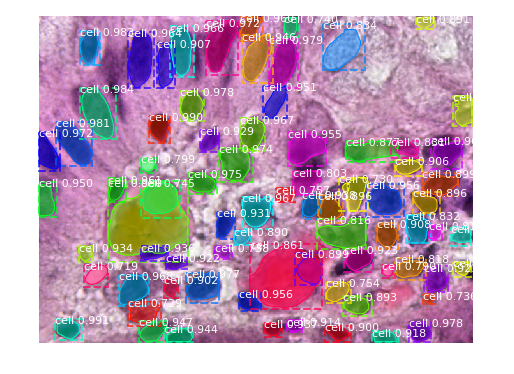

time: 2.08 s


In [24]:
# check a random image from test set
image_id = 40 #random.choice(dataset_test.image_ids)
image = dataset_test.load_image(image_id)
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [25]:
# prepare output for submission
out = []
for image_id in dataset_test.image_ids:
    source_id = dataset_test.image_info[image_id]["id"]
    image = dataset_test.load_image(image_id)
    results = model.detect([image], verbose=0)
    masks = results[0]["masks"]
    masks = nuke.remove_overlaps(masks)
    rles = [nuke.rle_encoding(masks[:,:,m]) for m in range(masks.shape[2])]
    for rle in rles:
        out.append(dict(ImageId=source_id, EncodedPixels=rle))
df = pd.DataFrame(out)

[root:INFO]:starting (cellevents.py:36, time=21:32)


time: 44.4 s


In [26]:
len(df.ImageId.unique())

[root:INFO]:starting (cellevents.py:36, time=21:32)


65

time: 2.74 ms


In [27]:
# na mask after overlaps removed
df=df[["ImageId", "EncodedPixels"]].dropna()
df.to_csv("out.csv", index=False)
pd.read_csv("out.csv").head()

[root:INFO]:starting (cellevents.py:36, time=21:32)


,ImageId,EncodedPixels
0,38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990...,9655 2 9908 8 10163 10 10418 11 10674 12 10929...
1,38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990...,54467 3 54721 7 54975 11 55230 12 55485 14 557...
2,38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990...,23333 4 23588 6 23843 8 24098 10 24354 10 2460...
3,38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990...,47926 3 48181 6 48436 8 48691 9 48947 10 49203...
4,38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990...,36836 4 37090 7 37345 9 37601 9 37856 11 38112...


time: 42.8 ms


In [28]:
print(len(df))
df.ImageId.value_counts()

[root:INFO]:starting (cellevents.py:36, time=21:32)


3012


d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896    150
78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d    150
432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580    150
550450e4bff4036fd671decdc5d42fec23578198d6a2fd79179c4368b9d6da18    150
52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde    122
3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26    114
43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af    112
699f2992cd71e2e28cf45f81347ff22e76b37541ce88087742884cd0e9aadc68    109
b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3     98
fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f     91
df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8     87
912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406     83
472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71     76
1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1

time: 7.63 ms
